In [25]:
import numpy as np
import pandas as pd
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_convergence, plot_objective
from rl4greencrab.envs.green_crab_monthly_env import greenCrabMonthEnv
from rl4greencrab.envs.green_crab_monthly_env_norm import greenCrabMonthEnvNormalized
from rl4greencrab import evaluate_agent, multiConstAction, simulator
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from huggingface_hub import hf_hub_download
from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC, RecurrentPPO

## Monthly Environment Simulation

In [69]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
}

In [2]:
def evaluateConstAct(x):
    config = {
        "w_mort_scale" : 600,
        "growth_k": 0.70,
    }
    env = greenCrabMonthEnv()
    agent = multiConstAction(env=env, action=np.array(x))
    # rewards = simulator(env, agent).simulate()
    # out = np.mean(rewards)
    m_reward = evaluate_agent(agent=agent, ray_remote=True).evaluate(n_eval_episodes=200)
    
    return - m_reward

In [3]:
%%time
max_action = 3000
res = gp_minimize(evaluateConstAct, 3*[(0.0, max_action)], n_calls = 100, verbose=True)
res.x

Iteration No: 1 started. Evaluating function at random point.


2025-03-19 06:25:33,566	INFO worker.py:1841 -- Started a local Ray instance.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.7570
Function value obtained: 5.4330
Current minimum: 5.4330
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3276
Function value obtained: 34.0992
Current minimum: 5.4330
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3208
Function value obtained: 11.4370
Current minimum: 5.4330
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3209
Function value obtained: 44.4285
Current minimum: 5.4330
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.3187
Function value obtained: 28.4736
Current minimum: 5.4330
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluati

[355.8983219691822, 0.0, 0.0]

In [7]:
# with nonNormalized env
evaluateConstAct(
    [355.8983219691822, 0.0, 0.0]
)

1.1385260587096782

In [8]:
import ray
ray.shutdown()

In [15]:
env = greenCrabMonthEnv(config)
agent = multiConstAction(env=env, action=np.array([0.0, 271.2268262115927, 0.0]))
constantData = simulator(env = env, agent = agent).simulate_full_named_obs_acts()
constantDataDF = pd.DataFrame(constantData)
constantDataDF.head()

,t,obs0,act0,act1,act2,rew,rep
0,0,0.0,0.0,271.226826,0.0,0.000000,0
1,1,0.0,0.0,271.226826,0.0,-0.007294,0
2,2,0.0,0.0,271.226826,0.0,-0.014588,0
3,3,0.0,0.0,271.226826,0.0,-0.021882,0
4,4,0.0,0.0,271.226826,0.0,-0.029176,0


<Axes: xlabel='t'>

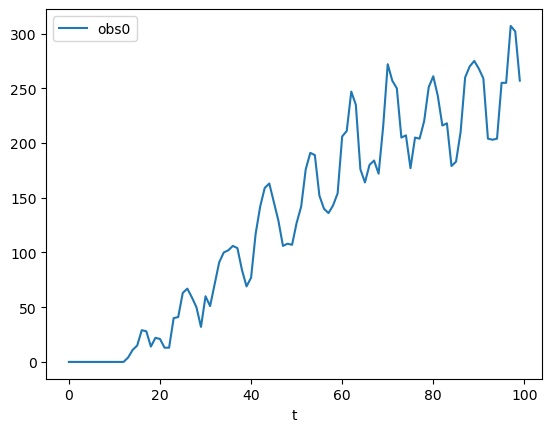

In [16]:
constantDataDF[constantDataDF.rep == 0].plot(x='t', y =['obs0'])

In [17]:
def environment_simulation(env, agent, reps=10, obs_names = None, acts_names = None):
    num_obs = np.prod(env.observation_space.shape)
    num_acts = np.prod(env.action_space.shape)
    obs_names = obs_names or [f'obs{i}' for i in range(num_obs)]
    acts_names = acts_names or [f'act{i}' for i in range(num_acts)]
    #
    data = {
        't': [],
        **{obsn: [] for obsn in obs_names},
        **{actn: [] for actn in acts_names},
        'rew': [],
        'rep': [],
        'crab_pop':[]
    }
    env = env
    agent = agent
    for rep in range(reps): # try score as average of 100 replicates, still a noisy measure
        episode_reward = 0.0
        observation, _ = env.reset()
        for t in range(env.Tmax):
            action, _ = agent.predict(observation, deterministic=True)
            #
            data['rew'].append(episode_reward)
            data['rep'].append(rep)
            data['t'].append(t)
            data['crab_pop'].append(env.state)
            for idx, obs_name in enumerate(obs_names):
                data[obs_name].append(observation[idx])
            for idx, act_name in enumerate(acts_names):
                data[act_name].append(action[idx])
            #
            observation, reward, terminated, done, info = env.step(action)
            episode_reward += reward
            #
            if terminated or done:
                break
    return data

In [19]:
agent = multiConstAction(env=env, action=np.array([0.0, 0, 0.0]))
constantData = environment_simulation(env, agent)
constantDataDF = pd.DataFrame(constantData)
constantDataDF.head()

,t,obs0,act0,act1,act2,rew,rep,crab_pop
0,0,0.0,0.0,0.0,0.0,0.000000,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,0.0,0.0,0.0,0.0,-0.264997,0,"[0.1498705496227185, 9.969669370865697, 189.21..."
2,2,0.0,0.0,0.0,0.0,-0.529996,0,"[0.0008666805064259568, 0.39045348585339085, 1..."
3,3,0.0,0.0,0.0,0.0,-0.794996,0,"[2.0281387879660194e-07, 0.002791424345339204,..."
4,4,0.0,0.0,0.0,0.0,-1.059996,0,"[1.4083651043444655e-12, 7.163248618127175e-07..."


In [20]:
crab_pop_df = pd.DataFrame(constantDataDF[constantDataDF['rep']==0]['crab_pop'].tolist(), columns=[f'crab_pop_{i}' for i in range(len(constantDataDF['crab_pop'][0]))])
crab_pop_df['t'] = constantDataDF['t']
crab_pop_df.head()

,crab_pop_0,crab_pop_1,crab_pop_2,crab_pop_3,crab_pop_4,crab_pop_5,crab_pop_6,crab_pop_7,crab_pop_8,crab_pop_9,...,crab_pop_12,crab_pop_13,crab_pop_14,crab_pop_15,crab_pop_16,crab_pop_17,crab_pop_18,crab_pop_19,crab_pop_20,t
0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,1.498705e-01,9.969669e+00,189.217726,1186.672837,2310.077708,1719.950595,519.484390,69.525034,74.739850,302.821863,...,1097.095691,778.987220,621.862577,689.658886,763.755173,761.408266,718.135378,579.551348,316.019362,1
2,8.666805e-04,3.904535e-01,15.910246,206.748309,1026.288076,2020.623105,1736.108918,689.117243,148.120850,143.703183,...,1152.184154,988.939203,740.424132,702.379418,766.062930,788.838030,741.346119,596.392479,328.215505,2
3,2.028139e-07,2.791424e-03,0.950750,25.033345,233.544252,970.161267,1827.020897,1659.272403,758.002740,223.599814,...,1018.623500,1106.864588,904.955761,763.397609,777.081251,800.652907,761.596527,615.703985,336.952832,3
4,1.408365e-12,7.163249e-07,0.007536,1.977688,38.639842,277.765816,975.364092,1706.731134,1546.388944,754.027596,...,791.199857,1076.500441,1037.592980,866.539314,811.312107,820.461870,788.508211,638.999264,350.218075,4


In [21]:
def plot_selected_sizes(expanded_df:pd.DataFrame, selected_sizes):
    plt.figure(figsize=(12, 8))
    time = expanded_df['t']  # Time column

    # If no sizes selected, show a placeholder message
    if not selected_sizes:
        plt.text(0.5, 0.5, 'No sizes selected', fontsize=20, ha='center', va='center')
        plt.axis('off')
        plt.show()
        return

    # Plot each selected size
    for col in selected_sizes:
        plt.plot(time, expanded_df[col], label=col)

    # Customize the plot
    plt.title("Green Crab Population Change Over Time", fontsize=16)
    plt.xlabel("Time (t)", fontsize=14)
    plt.ylabel("Population", fontsize=14)
    plt.legend(title="Crab Sizes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    plt.tight_layout()

    # Show the plot
    plt.show()

# Create a multi-select widget for crab size columns
crab_pop_columns = [col for col in crab_pop_df.columns if col.startswith('crab_pop_')]
size_selector = widgets.SelectMultiple(
    options=crab_pop_columns,
    value=[crab_pop_columns[0]],  # Default selection
    description='Sizes',
    disabled=False
)
# Create an interactive plot
interact(lambda selected_sizes: plot_selected_sizes(crab_pop_df, selected_sizes), selected_sizes=size_selector);

interactive(children=(SelectMultiple(description='Sizes', index=(0,), options=('crab_pop_0', 'crab_pop_1', 'cr…

### normalized environment

In [22]:
config

{'w_mort_scale': 350, 'growth_k': 0.87}

In [14]:
env = greenCrabMonthEnvNormalized()
agent = multiConstAction(env=env, action=np.array([-0.22713126, -0.21056502, -0.16036674]))

In [15]:
def evaluateConstAct(x):
    env = greenCrabMonthEnvNormalized()
    agent = multiConstAction(env=env, action=np.array(x))
    # rewards = simulator(env, agent).simulate()
    # out = np.mean(rewards)
    m_reward = evaluate_agent(agent=agent, ray_remote=True).evaluate(n_eval_episodes=200)
    
    return - m_reward

In [11]:
# normalized constant action
def normalized_action(act, max_act):
    max_action = max_act
    constant_act = np.array(act)
    return constant_act * 2 / max_action - 1 

In [12]:
normalized_action([355.8983219691822, 0.0, 0.0], max_action)

array([-0.76273445, -1.        , -1.        ])

In [23]:
evaluateConstAct([-0.66273445, -1.        , -1.        ])

1.6184826906082213

In [24]:
import ray
ray.shutdown()

In [17]:
agent = multiConstAction(env=env, action=np.array([-1.        , -0.71918212, -1.        ]))

In [18]:
constantData = simulator(env = env, agent = agent).simulate_full_named_obs_acts()
constantDataDF = pd.DataFrame(constantData)
constantDataDF.head()

,t,obs0,act0,act1,act2,rew,rep
0,0,-1.0,-1.0,-0.719182,-1.0,0.000000,0
1,1,-1.0,-1.0,-0.719182,-1.0,-0.011294,0
2,2,-1.0,-1.0,-0.719182,-1.0,-0.022588,0
3,3,-1.0,-1.0,-0.719182,-1.0,-0.033882,0
4,4,-1.0,-1.0,-0.719182,-1.0,-0.045176,0


<Axes: xlabel='t'>

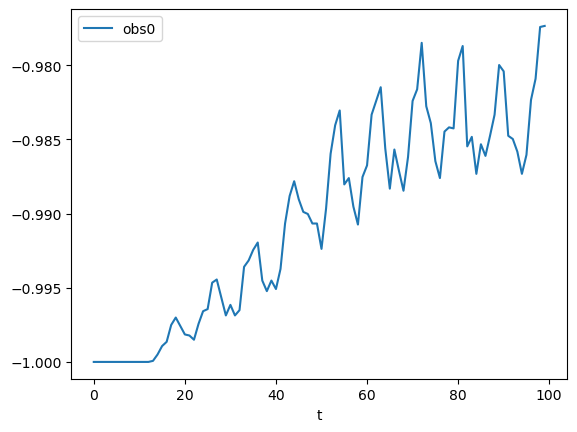

In [19]:
constantDataDF[constantDataDF.rep == 0].plot(x='t', y =['obs0'])

## Loading and evaluating trained models

In [52]:
repo_id = "jimjiang203/greencrabPPO"
td3_path = hf_hub_download(repo_id=repo_id, filename='td3_gcmonthnorm.zip')
ppo_path = hf_hub_download(repo_id=repo_id, filename='PPO_gcmenorm.zip')
reppo_path = hf_hub_download(repo_id=repo_id, filename='RecurrentPPO_gcmenorm.zip')
tqc_path = hf_hub_download(repo_id=repo_id, filename='TQC_gcmenorm.zip')

In [78]:
evalEnv = greenCrabMonthEnvNormalized(config)

In [65]:
td3Agent = TD3.load("TD3_gcmenorm", device="cpu")
ppoAgent = PPO.load("PPO_gcmenorm", device="cpu")
tqcAgent = TQC.load("TQC_gcmenorm", device="cpu")
recurrentPPOAgent = RecurrentPPO.load("RecurrentPPO_gcmenorm", device="cpu")

In [79]:
N_EPS = 30

ppo_rew = evaluate_agent(agent=ppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
td3_rew = evaluate_agent(agent=td3Agent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
tqc_rew = evaluate_agent(agent=tqcAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
reppo_rew = evaluate_agent(agent=recurrentPPOAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)

2025-03-19 04:38:59,817	INFO worker.py:1841 -- Started a local Ray instance.


In [80]:
import ray
ray.shutdown()

In [81]:
print(f"""
PPO mean rew = {ppo_rew}
TQC mean rew = {tqc_rew}
TD3 mean rew = {td3_rew}
RecurrentPPO mean rew = {reppo_rew}
""")


PPO mean rew = -1.4436634001656818
TQC mean rew = -1.5420358128382918
TD3 mean rew = -1.632466502533743
RecurrentPPO mean rew = -3.1739803850667014



### RecurrentPPO plot

In [74]:
reppoData = simulator(env = evalEnv, agent = recurrentPPOAgent).simulate_full_named_obs_acts()
reppoDataDF = pd.DataFrame(reppoData)
reppoDataDF.head()

,t,obs0,act0,act1,act2,rew,rep
0,0,-1.0,-1.0,-1.0,-0.841429,0.000000,0
1,1,-1.0,-1.0,-1.0,-0.841429,-0.031775,0
2,2,-1.0,-1.0,-1.0,-0.841429,-0.063551,0
3,3,-1.0,-1.0,-1.0,-0.841429,-0.095326,0
4,4,-1.0,-1.0,-1.0,-0.841429,-0.127101,0


<Axes: xlabel='t'>

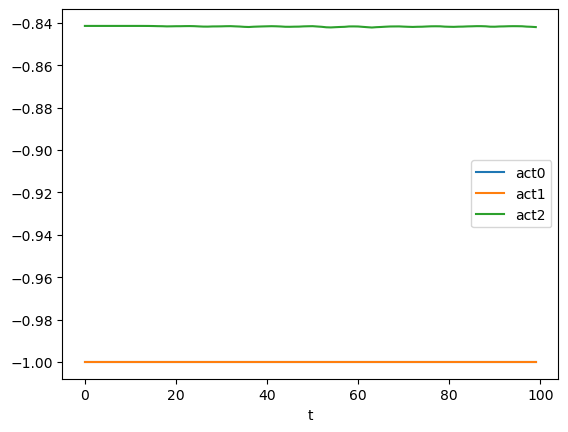

In [75]:
reppoDataDF[reppoDataDF.rep == 0].plot(x='t', y =['act0', 'act1', 'act2'])

<Axes: xlabel='t'>

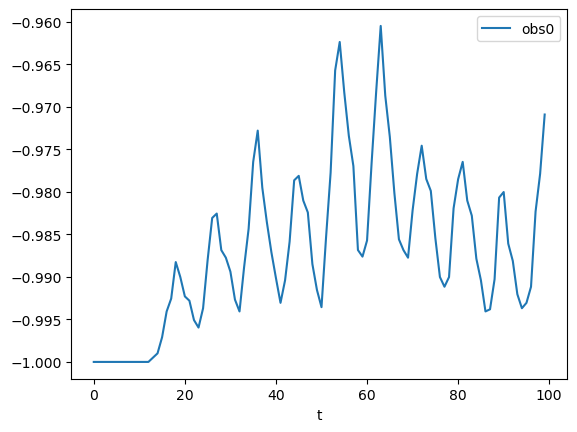

In [76]:
reppoDataDF[reppoDataDF.rep == 0].plot(x='t', y =['obs0'])